# Neuron to neuron connections

While Nengo is often used with deep learning
and NEF style networks,
it can also be used for lower level models
in which each neuron to neuron connection
is explicitly specified.

In these examples, we connect a `pre` population
to a `post` population with different sets of
specified connection weights.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_loihi

## 1. Simple fan-out

In this example,
a neuron is connected to several downstream neurons
with increasing synaptic strength.

Synaptic strengths are defined through the `transform`
of a `nengo.Connection`.
While a `Connection` between two ensembles
operates on their vector representations,
a connection between two ensemble's neuron values
operates directly on neural activities (i.e., spikes).

In [2]:
with nengo.Network() as model:
    pre = nengo.Ensemble(1, dimensions=1, gain=[1], bias=[1.05])
    post = nengo.Ensemble(6, dimensions=1, gain=np.ones(6), bias=np.zeros(6))

    transform = np.linspace(0.01, 0.15, post.n_neurons)
    transform = transform.reshape((post.n_neurons, pre.n_neurons))
    nengo.Connection(pre.neurons, post.neurons, transform=transform)

    pre_probe = nengo.Probe(pre.neurons)
    post_probe = nengo.Probe(post.neurons)

### Running the network in Nengo

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()

/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:580: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

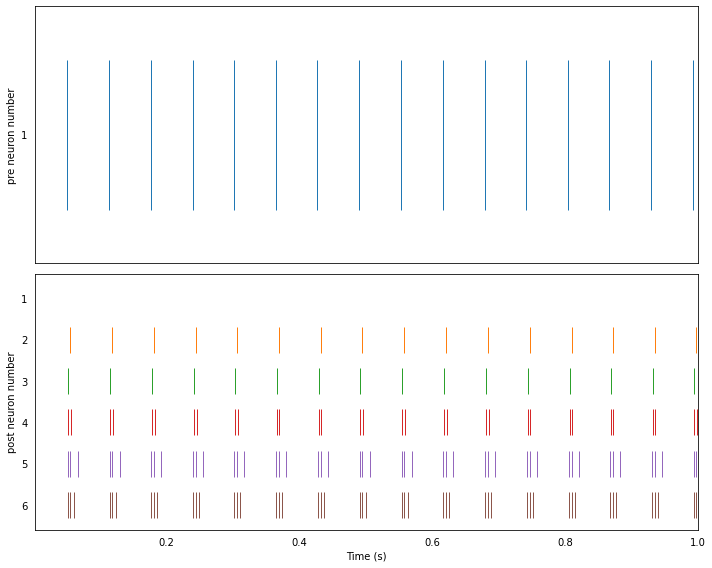

In [4]:
def plot_rasters(t, data):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    rasterplot(t, data[pre_probe])
    plt.xticks(())
    plt.ylabel("pre neuron number")
    plt.subplot(2, 1, 2)
    rasterplot(t, data[post_probe])
    plt.ylabel("post neuron number")
    plt.xlabel("Time (s)")
    plt.tight_layout()


plot_rasters(t, sim.data)

### Running the network with NengoLoihi

In [5]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()

/home/travis/build/nengo/nengo-loihi/nengo_loihi/builder/ensemble.py:157: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on LIF neurons. On the chip, all values will be initialized to zero.
  % (key, type(neuron_type).__name__)
/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:580: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


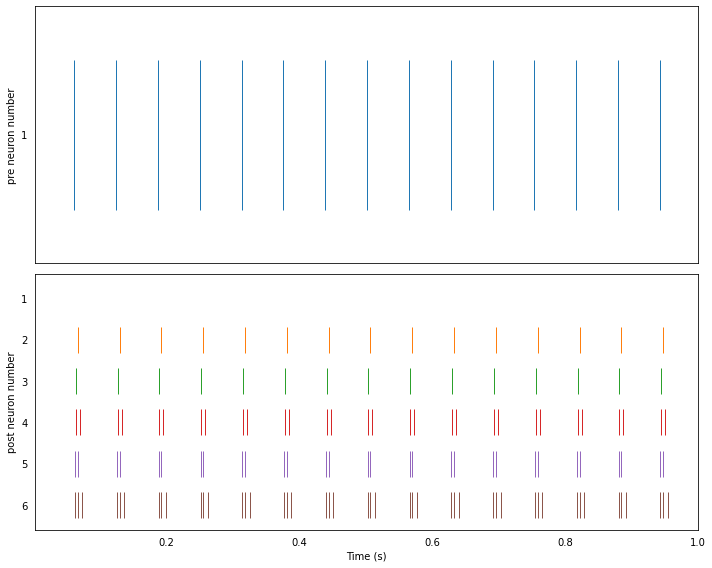

In [6]:
plot_rasters(t, sim.data)

## 2. One-to-one connections

In this example, two populations of equal size
are connected one-to-one with random
biases in the `pre` population and
random excitatory connection weights.

In [7]:
rng = np.random.RandomState(seed=10)
n_neurons = 5

with nengo.Network() as model:
    pre = nengo.Ensemble(
        n_neurons,
        1,
        gain=np.ones(n_neurons),
        bias=rng.uniform(low=1.0, high=1.5, size=n_neurons),
    )
    post = nengo.Ensemble(
        n_neurons, 1, gain=np.ones(n_neurons), bias=np.zeros(n_neurons)
    )

    transform = np.zeros((n_neurons, n_neurons))
    di = np.diag_indices(n_neurons)
    transform[di] = rng.uniform(low=0.0, high=0.2, size=n_neurons)
    nengo.Connection(pre.neurons, post.neurons, transform=transform)

    pre_probe = nengo.Probe(pre.neurons)
    post_probe = nengo.Probe(post.neurons)

### Running the network in Nengo

/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:580: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

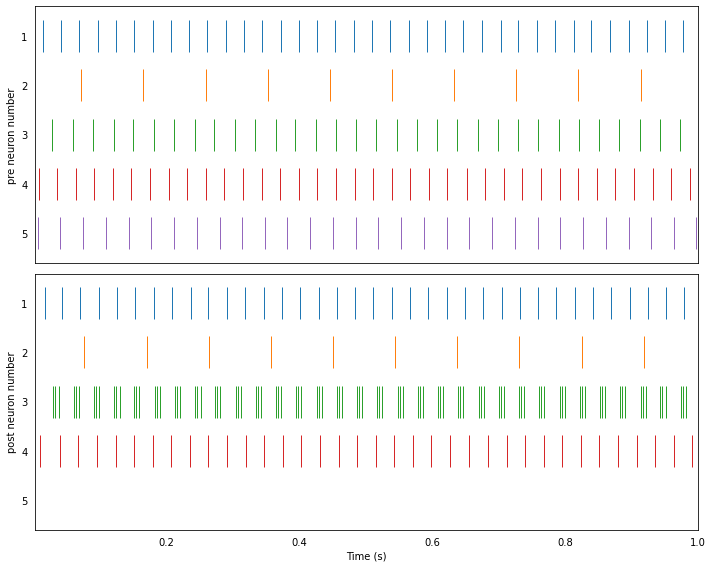

In [8]:
with nengo.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)

### Running the network with NengoLoihi

/home/travis/build/nengo/nengo-loihi/nengo_loihi/builder/ensemble.py:157: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on LIF neurons. On the chip, all values will be initialized to zero.
  % (key, type(neuron_type).__name__)
/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:580: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


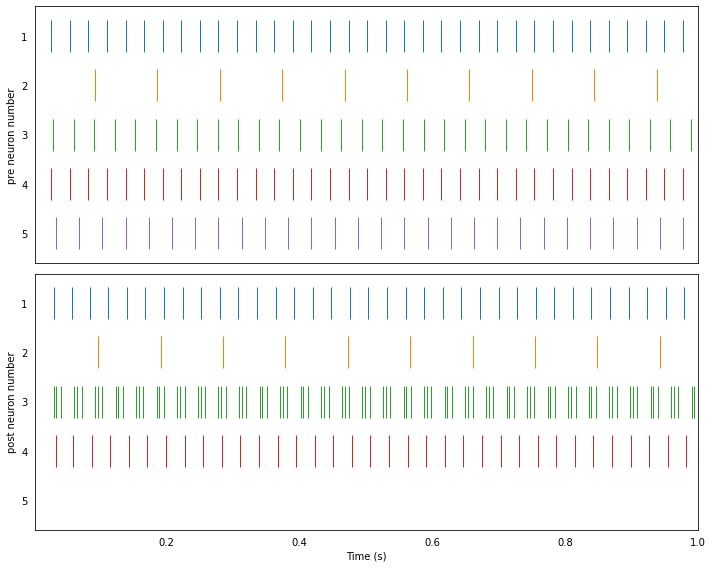

In [9]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)

## 3. Fixed probability connections

In this example, two populations are recurrently connected
(i.e., `post` is also connected back to `pre`).
There is a fixed probability of two neurons
being connected in either direction,
a fixed probability of an inhibitory connection,
and all connections have the same weight.

In [10]:
rng = np.random.RandomState(seed=100)
inhibitory = 0.5  # 50% inhibitory connections
connection_prob = 0.6  # 60% probability of being connected
n_neurons = 25

with nengo.Network() as model:
    pre = nengo.Ensemble(
        n_neurons,
        1,
        gain=np.ones(n_neurons),
        bias=rng.uniform(low=-2, high=2, size=n_neurons),
    )
    post = nengo.Ensemble(
        n_neurons,
        1,
        gain=np.ones(n_neurons),
        bias=rng.uniform(low=-2, high=2, size=n_neurons),
    )

    pre_post = np.ones((n_neurons, n_neurons)) * 0.05
    # Make some inhibitory
    pre_post[rng.rand(n_neurons, n_neurons) <= inhibitory] *= -1
    # Remove 1 - connection_prob connections
    pre_post[rng.rand(n_neurons, n_neurons) > connection_prob] = 0
    nengo.Connection(pre.neurons, post.neurons, transform=pre_post)

    post_pre = np.ones((n_neurons, n_neurons)) * 0.05
    post_pre[rng.rand(n_neurons, n_neurons) <= inhibitory] *= -1
    post_pre[rng.rand(n_neurons, n_neurons) > connection_prob] = 0
    nengo.Connection(post.neurons, pre.neurons, transform=post_pre)

    pre_probe = nengo.Probe(pre.neurons)
    post_probe = nengo.Probe(post.neurons)

### Running the network in Nengo

/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:580: RuntimeWarning: invalid value encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))
/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:584: UserWarning: Non-finite values detected in `max_rates`; this probably means that `gain` was too small.
  "Non-finite values detected in `max_rates`; this "


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

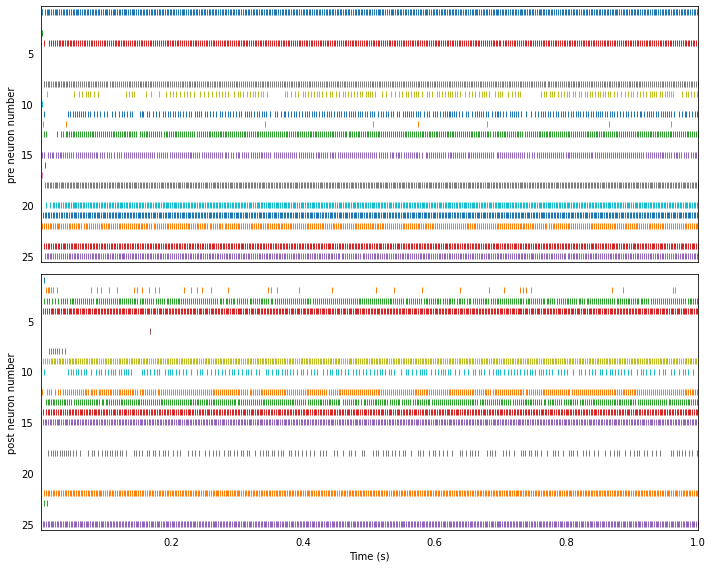

In [11]:
with nengo.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)

### Running the network with NengoLoihi

/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:580: RuntimeWarning: invalid value encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))
/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo/neurons.py:584: UserWarning: Non-finite values detected in `max_rates`; this probably means that `gain` was too small.
  "Non-finite values detected in `max_rates`; this "
/home/travis/build/nengo/nengo-loihi/nengo_loihi/builder/ensemble.py:157: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on LIF neurons. On the chip, all values will be initialized to zero.
  % (key, type(neuron_type).__name__)


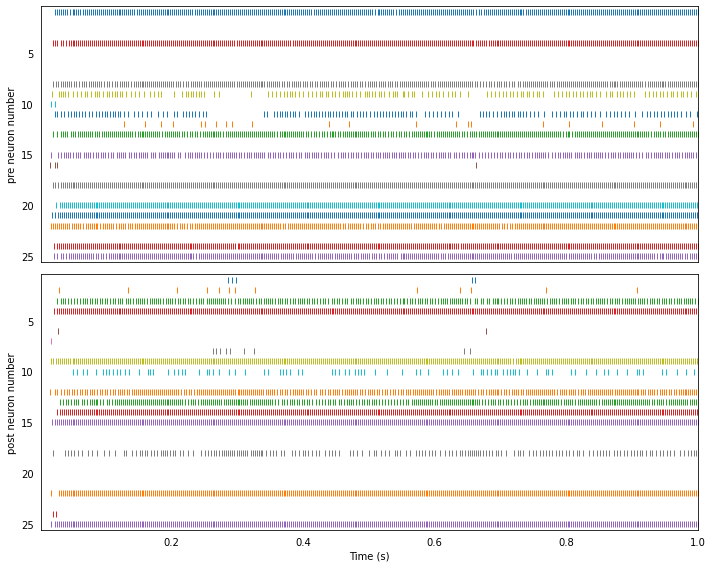

In [12]:
with nengo_loihi.Simulator(model) as sim:
    sim.run(1)
t = sim.trange()
plot_rasters(t, sim.data)